## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [28]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [30]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


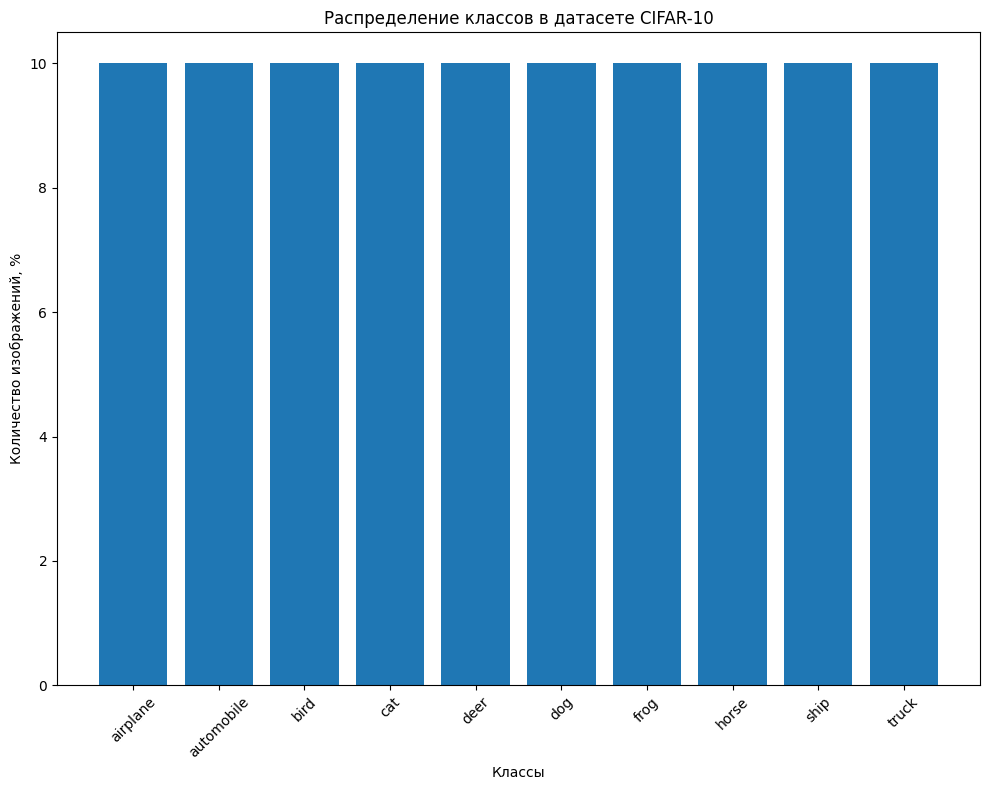

In [31]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Трансформация для тестовых данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

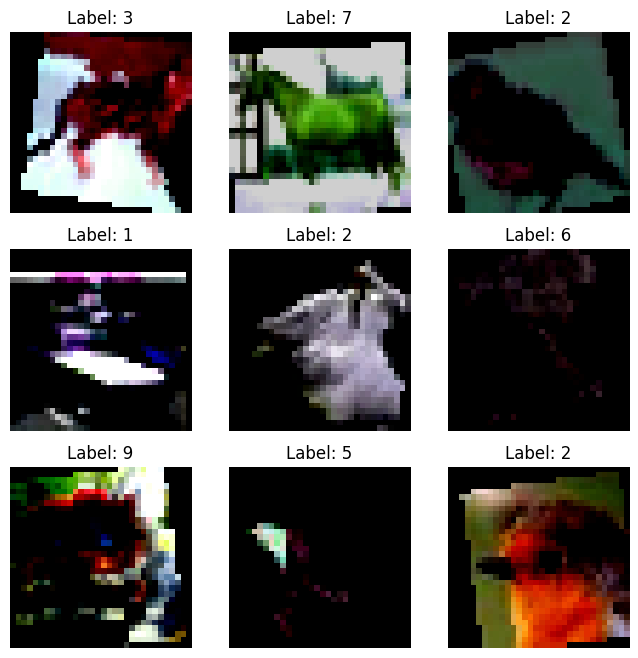

In [32]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Напишем функции train и test

In [33]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc=f'Train epoch {epoch + 1}/{epochs}')
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 'accuracy': f'{correct / total:.4f}'})

        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs} -> Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_correct / val_total:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

In [34]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [35]:
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Модель
model = CustomCNN(num_classes=10)
print('Model params: ', count_parameters(model))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Планировщик обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# DataLoader'ы
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  3064586


Обучите модель и постройте графики обучения

In [36]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=num_epochs
)

Train epoch 1/50: 100%|█████████████| 625/625 [00:57<00:00, 10.84it/s, loss=1.7017, accuracy=0.3683]


Epoch 1/50 -> Train Loss: 1.7017, Train Acc: 0.3683, Val Loss: 1.2948, Val Acc: 0.5259


Train epoch 2/50: 100%|█████████████| 625/625 [00:55<00:00, 11.35it/s, loss=1.3632, accuracy=0.5097]


Epoch 2/50 -> Train Loss: 1.3632, Train Acc: 0.5097, Val Loss: 1.0578, Val Acc: 0.6122


Train epoch 3/50: 100%|█████████████| 625/625 [00:56<00:00, 11.15it/s, loss=1.1760, accuracy=0.5784]


Epoch 3/50 -> Train Loss: 1.1760, Train Acc: 0.5784, Val Loss: 0.9446, Val Acc: 0.6665


Train epoch 4/50: 100%|█████████████| 625/625 [00:55<00:00, 11.32it/s, loss=1.0682, accuracy=0.6195]


Epoch 4/50 -> Train Loss: 1.0682, Train Acc: 0.6195, Val Loss: 0.8487, Val Acc: 0.6979


Train epoch 5/50: 100%|█████████████| 625/625 [00:57<00:00, 10.88it/s, loss=0.9847, accuracy=0.6543]


Epoch 5/50 -> Train Loss: 0.9847, Train Acc: 0.6543, Val Loss: 0.8107, Val Acc: 0.7130


Train epoch 6/50: 100%|█████████████| 625/625 [00:55<00:00, 11.24it/s, loss=0.9323, accuracy=0.6694]


Epoch 6/50 -> Train Loss: 0.9323, Train Acc: 0.6694, Val Loss: 0.7836, Val Acc: 0.7314


Train epoch 7/50: 100%|█████████████| 625/625 [00:56<00:00, 11.04it/s, loss=0.8933, accuracy=0.6850]


Epoch 7/50 -> Train Loss: 0.8933, Train Acc: 0.6850, Val Loss: 0.7638, Val Acc: 0.7348


Train epoch 8/50: 100%|█████████████| 625/625 [00:56<00:00, 11.12it/s, loss=0.8535, accuracy=0.6995]


Epoch 8/50 -> Train Loss: 0.8535, Train Acc: 0.6995, Val Loss: 0.7733, Val Acc: 0.7284


Train epoch 9/50: 100%|█████████████| 625/625 [00:57<00:00, 10.89it/s, loss=0.8285, accuracy=0.7084]


Epoch 9/50 -> Train Loss: 0.8285, Train Acc: 0.7084, Val Loss: 0.7157, Val Acc: 0.7500


Train epoch 10/50: 100%|████████████| 625/625 [00:56<00:00, 11.11it/s, loss=0.7979, accuracy=0.7197]


Epoch 10/50 -> Train Loss: 0.7979, Train Acc: 0.7197, Val Loss: 0.6763, Val Acc: 0.7657


Train epoch 11/50: 100%|████████████| 625/625 [00:56<00:00, 11.11it/s, loss=0.7066, accuracy=0.7531]


Epoch 11/50 -> Train Loss: 0.7066, Train Acc: 0.7531, Val Loss: 0.6197, Val Acc: 0.7851


Train epoch 12/50: 100%|████████████| 625/625 [00:58<00:00, 10.70it/s, loss=0.6865, accuracy=0.7588]


Epoch 12/50 -> Train Loss: 0.6865, Train Acc: 0.7588, Val Loss: 0.6099, Val Acc: 0.7912


Train epoch 13/50: 100%|████████████| 625/625 [00:56<00:00, 11.14it/s, loss=0.6637, accuracy=0.7673]


Epoch 13/50 -> Train Loss: 0.6637, Train Acc: 0.7673, Val Loss: 0.6076, Val Acc: 0.7908


Train epoch 14/50: 100%|████████████| 625/625 [00:56<00:00, 10.98it/s, loss=0.6579, accuracy=0.7692]


Epoch 14/50 -> Train Loss: 0.6579, Train Acc: 0.7692, Val Loss: 0.5806, Val Acc: 0.8073


Train epoch 15/50: 100%|████████████| 625/625 [00:56<00:00, 11.13it/s, loss=0.6401, accuracy=0.7740]


Epoch 15/50 -> Train Loss: 0.6401, Train Acc: 0.7740, Val Loss: 0.5939, Val Acc: 0.7990


Train epoch 16/50: 100%|████████████| 625/625 [00:57<00:00, 10.94it/s, loss=0.6227, accuracy=0.7815]


Epoch 16/50 -> Train Loss: 0.6227, Train Acc: 0.7815, Val Loss: 0.5731, Val Acc: 0.8080


Train epoch 17/50: 100%|████████████| 625/625 [00:55<00:00, 11.17it/s, loss=0.6121, accuracy=0.7863]


Epoch 17/50 -> Train Loss: 0.6121, Train Acc: 0.7863, Val Loss: 0.5617, Val Acc: 0.8106


Train epoch 18/50: 100%|████████████| 625/625 [00:55<00:00, 11.28it/s, loss=0.6010, accuracy=0.7899]


Epoch 18/50 -> Train Loss: 0.6010, Train Acc: 0.7899, Val Loss: 0.5690, Val Acc: 0.8049


Train epoch 19/50: 100%|████████████| 625/625 [00:57<00:00, 10.87it/s, loss=0.5962, accuracy=0.7915]


Epoch 19/50 -> Train Loss: 0.5962, Train Acc: 0.7915, Val Loss: 0.5583, Val Acc: 0.8110


Train epoch 20/50: 100%|████████████| 625/625 [00:55<00:00, 11.24it/s, loss=0.5845, accuracy=0.7924]


Epoch 20/50 -> Train Loss: 0.5845, Train Acc: 0.7924, Val Loss: 0.5396, Val Acc: 0.8176


Train epoch 21/50: 100%|████████████| 625/625 [00:56<00:00, 11.12it/s, loss=0.5353, accuracy=0.8123]


Epoch 21/50 -> Train Loss: 0.5353, Train Acc: 0.8123, Val Loss: 0.5160, Val Acc: 0.8296


Train epoch 22/50: 100%|████████████| 625/625 [00:55<00:00, 11.31it/s, loss=0.5260, accuracy=0.8178]


Epoch 22/50 -> Train Loss: 0.5260, Train Acc: 0.8178, Val Loss: 0.5139, Val Acc: 0.8299


Train epoch 23/50: 100%|████████████| 625/625 [00:56<00:00, 10.97it/s, loss=0.5139, accuracy=0.8196]


Epoch 23/50 -> Train Loss: 0.5139, Train Acc: 0.8196, Val Loss: 0.5205, Val Acc: 0.8237


Train epoch 24/50: 100%|████████████| 625/625 [00:55<00:00, 11.28it/s, loss=0.5031, accuracy=0.8244]


Epoch 24/50 -> Train Loss: 0.5031, Train Acc: 0.8244, Val Loss: 0.5101, Val Acc: 0.8309


Train epoch 25/50: 100%|████████████| 625/625 [00:56<00:00, 11.08it/s, loss=0.4998, accuracy=0.8245]


Epoch 25/50 -> Train Loss: 0.4998, Train Acc: 0.8245, Val Loss: 0.5131, Val Acc: 0.8253


Train epoch 26/50: 100%|████████████| 625/625 [00:56<00:00, 11.14it/s, loss=0.4920, accuracy=0.8286]


Epoch 26/50 -> Train Loss: 0.4920, Train Acc: 0.8286, Val Loss: 0.4973, Val Acc: 0.8352


Train epoch 27/50: 100%|████████████| 625/625 [00:55<00:00, 11.16it/s, loss=0.4894, accuracy=0.8273]


Epoch 27/50 -> Train Loss: 0.4894, Train Acc: 0.8273, Val Loss: 0.4954, Val Acc: 0.8360


Train epoch 28/50: 100%|████████████| 625/625 [00:55<00:00, 11.27it/s, loss=0.4825, accuracy=0.8314]


Epoch 28/50 -> Train Loss: 0.4825, Train Acc: 0.8314, Val Loss: 0.5033, Val Acc: 0.8361


Train epoch 29/50: 100%|████████████| 625/625 [00:55<00:00, 11.24it/s, loss=0.4662, accuracy=0.8361]


Epoch 29/50 -> Train Loss: 0.4662, Train Acc: 0.8361, Val Loss: 0.5049, Val Acc: 0.8346


Train epoch 30/50: 100%|████████████| 625/625 [00:57<00:00, 10.95it/s, loss=0.4669, accuracy=0.8358]


Epoch 30/50 -> Train Loss: 0.4669, Train Acc: 0.8358, Val Loss: 0.5005, Val Acc: 0.8365


Train epoch 31/50: 100%|████████████| 625/625 [00:56<00:00, 11.07it/s, loss=0.4458, accuracy=0.8430]


Epoch 31/50 -> Train Loss: 0.4458, Train Acc: 0.8430, Val Loss: 0.4814, Val Acc: 0.8418


Train epoch 32/50: 100%|████████████| 625/625 [00:57<00:00, 10.91it/s, loss=0.4362, accuracy=0.8473]


Epoch 32/50 -> Train Loss: 0.4362, Train Acc: 0.8473, Val Loss: 0.4816, Val Acc: 0.8443


Train epoch 33/50: 100%|████████████| 625/625 [00:56<00:00, 10.98it/s, loss=0.4310, accuracy=0.8485]


Epoch 33/50 -> Train Loss: 0.4310, Train Acc: 0.8485, Val Loss: 0.4798, Val Acc: 0.8442


Train epoch 34/50: 100%|████████████| 625/625 [00:58<00:00, 10.73it/s, loss=0.4267, accuracy=0.8496]


Epoch 34/50 -> Train Loss: 0.4267, Train Acc: 0.8496, Val Loss: 0.4805, Val Acc: 0.8467


Train epoch 35/50: 100%|████████████| 625/625 [00:57<00:00, 10.79it/s, loss=0.4248, accuracy=0.8490]


Epoch 35/50 -> Train Loss: 0.4248, Train Acc: 0.8490, Val Loss: 0.4855, Val Acc: 0.8419


Train epoch 36/50: 100%|████████████| 625/625 [00:56<00:00, 11.07it/s, loss=0.4246, accuracy=0.8496]


Epoch 36/50 -> Train Loss: 0.4246, Train Acc: 0.8496, Val Loss: 0.4771, Val Acc: 0.8438


Train epoch 37/50: 100%|████████████| 625/625 [00:58<00:00, 10.63it/s, loss=0.4147, accuracy=0.8539]


Epoch 37/50 -> Train Loss: 0.4147, Train Acc: 0.8539, Val Loss: 0.4798, Val Acc: 0.8434


Train epoch 38/50: 100%|████████████| 625/625 [00:57<00:00, 10.89it/s, loss=0.4125, accuracy=0.8554]


Epoch 38/50 -> Train Loss: 0.4125, Train Acc: 0.8554, Val Loss: 0.4754, Val Acc: 0.8475


Train epoch 39/50: 100%|████████████| 625/625 [00:56<00:00, 11.07it/s, loss=0.4138, accuracy=0.8546]


Epoch 39/50 -> Train Loss: 0.4138, Train Acc: 0.8546, Val Loss: 0.4790, Val Acc: 0.8449


Train epoch 40/50: 100%|████████████| 625/625 [00:58<00:00, 10.76it/s, loss=0.4104, accuracy=0.8557]


Epoch 40/50 -> Train Loss: 0.4104, Train Acc: 0.8557, Val Loss: 0.4838, Val Acc: 0.8451


Train epoch 41/50: 100%|████████████| 625/625 [00:55<00:00, 11.18it/s, loss=0.3922, accuracy=0.8611]


Epoch 41/50 -> Train Loss: 0.3922, Train Acc: 0.8611, Val Loss: 0.4702, Val Acc: 0.8448


Train epoch 42/50: 100%|████████████| 625/625 [00:56<00:00, 11.10it/s, loss=0.3872, accuracy=0.8636]


Epoch 42/50 -> Train Loss: 0.3872, Train Acc: 0.8636, Val Loss: 0.4781, Val Acc: 0.8457


Train epoch 43/50: 100%|████████████| 625/625 [00:56<00:00, 11.10it/s, loss=0.3828, accuracy=0.8656]


Epoch 43/50 -> Train Loss: 0.3828, Train Acc: 0.8656, Val Loss: 0.4769, Val Acc: 0.8472


Train epoch 44/50: 100%|████████████| 625/625 [00:56<00:00, 11.10it/s, loss=0.3791, accuracy=0.8659]


Epoch 44/50 -> Train Loss: 0.3791, Train Acc: 0.8659, Val Loss: 0.4685, Val Acc: 0.8484


Train epoch 45/50: 100%|████████████| 625/625 [00:55<00:00, 11.21it/s, loss=0.3819, accuracy=0.8646]


Epoch 45/50 -> Train Loss: 0.3819, Train Acc: 0.8646, Val Loss: 0.4715, Val Acc: 0.8446


Train epoch 46/50: 100%|████████████| 625/625 [00:55<00:00, 11.21it/s, loss=0.3812, accuracy=0.8653]


Epoch 46/50 -> Train Loss: 0.3812, Train Acc: 0.8653, Val Loss: 0.4691, Val Acc: 0.8466


Train epoch 47/50: 100%|████████████| 625/625 [00:56<00:00, 10.97it/s, loss=0.3757, accuracy=0.8666]


Epoch 47/50 -> Train Loss: 0.3757, Train Acc: 0.8666, Val Loss: 0.4685, Val Acc: 0.8474


Train epoch 48/50: 100%|████████████| 625/625 [00:55<00:00, 11.17it/s, loss=0.3770, accuracy=0.8668]


Epoch 48/50 -> Train Loss: 0.3770, Train Acc: 0.8668, Val Loss: 0.4668, Val Acc: 0.8495


Train epoch 49/50: 100%|████████████| 625/625 [00:55<00:00, 11.19it/s, loss=0.3734, accuracy=0.8679]


Epoch 49/50 -> Train Loss: 0.3734, Train Acc: 0.8679, Val Loss: 0.4646, Val Acc: 0.8495


Train epoch 50/50: 100%|████████████| 625/625 [00:57<00:00, 10.94it/s, loss=0.3676, accuracy=0.8715]


Epoch 50/50 -> Train Loss: 0.3676, Train Acc: 0.8715, Val Loss: 0.4701, Val Acc: 0.8487


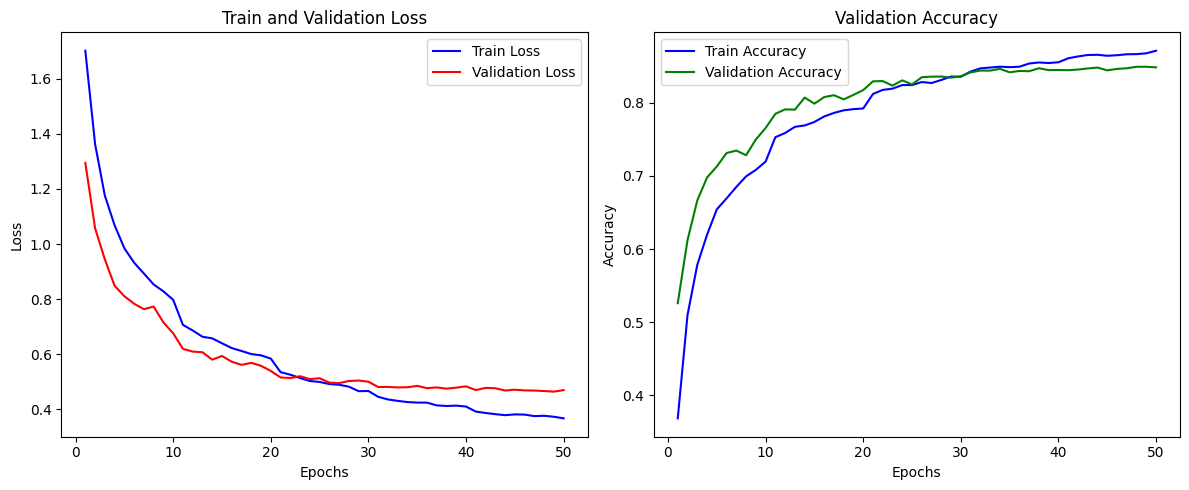

In [37]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [38]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4701
Test Accuracy: 0.8487


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов